In [15]:
# TO DO
# Save all prediction

In [1]:
# General imports
from __future__ import division
import sys
import ctypes
import numpy as np
import scipy.io
import platform
from math import *
import os
import glob
import json
opj = os.path.join
import warnings
warnings.filterwarnings('ignore')

# MRI analysis imports
import nibabel as nb
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.css as css
import popeye.og as og
import cifti
from joblib import Parallel, delayed
from scipy import signal


import ipdb
deb = ipdb.set_trace

In [2]:
from scipy.signal import fftconvolve, savgol_filter
from popeye.base import PopulationModel
from popeye.spinach import generate_og_receptive_field, generate_rf_timeseries_nomask

class CompressiveSpatialSummationModel(PopulationModel):
    
    r"""
    A Compressive Spatial Summation population receptive field model class    
    """
    
    def __init__(self, stimulus, hrf_model, cached_model_path=None, nuisance=None):
                
        PopulationModel.__init__(self, stimulus, hrf_model, cached_model_path, nuisance)

    # main method for deriving model time-series
    def generate_prediction(self, x, y, sigma, n, beta, baseline):
        
        # generate the RF
        rf = generate_og_receptive_field(
            x, y, sigma, self.stimulus.deg_x, self.stimulus.deg_y)
        
        # normalize by the integral
        rf /= ((2 * np.pi * sigma**2) * 1 /
               np.diff(self.stimulus.deg_x[0, 0:2])**2)
        
        # extract the stimulus time-series
        response = generate_rf_timeseries_nomask(self.stimulus.stim_arr, rf)
        
        # compression
        response **= n
        
        # convolve with the HRF
        hrf = self.hrf_model(self.hrf_delay, self.stimulus.tr_length)
        
        # convolve it with the stimulus
        model = fftconvolve(response, hrf)[0:len(response)]
        
        # units
        model /= np.max(model)
        
        # offset
        model += baseline
        
        # scale it by beta
        model *= beta

        return model

class CompressiveSpatialSummationModelFiltered(PopulationModel):
    
    r"""
    A Compressive Spatial Summation population receptive field model class
    Adapted to include a savgol_filter
    
    """
    
    def __init__(self, stimulus, hrf_model, cached_model_path=None, nuisance=None, sg_filter_window_length=120, sg_filter_polyorder=3, sg_filter_deriv = 0, tr=1.5):
                
        PopulationModel.__init__(self, stimulus, hrf_model, cached_model_path, nuisance)

        # sg filter
        self.sg_filter_window = np.int(sg_filter_window_length / tr)
        if self.sg_filter_window % 2 == 0:
            self.sg_filter_window += 1
        self.sg_filter_polyorder = sg_filter_polyorder
        self.sg_filter_deriv = sg_filter_deriv

    # main method for deriving model time-series
    def generate_prediction(self, x, y, sigma, n, beta, baseline):
        
        # generate the RF
        rf = generate_og_receptive_field(
            x, y, sigma, self.stimulus.deg_x, self.stimulus.deg_y)
        
        # normalize by the integral
        rf /= ((2 * np.pi * sigma**2) * 1 /
               np.diff(self.stimulus.deg_x[0, 0:2])**2)
        
        # extract the stimulus time-series
        response = generate_rf_timeseries_nomask(self.stimulus.stim_arr, rf)
        
        # compression
        response **= n
        
        # convolve with the HRF
        hrf = self.hrf_model(self.hrf_delay, self.stimulus.tr_length)
        
        # convolve it with the stimulus
        model = fftconvolve(response, hrf)[0:len(response)]
        
        # units
        model /= np.max(model)
        
        # at this point, add filtering with a savitzky-golay filter
        model_drift = savgol_filter(model, 
                                    window_length = self.sg_filter_window, 
                                    polyorder = self.sg_filter_polyorder,
                                    deriv = self.sg_filter_deriv, 
                                    mode = 'nearest')
        
        # demain model_drift, so baseline parameter is still interpretable
        model_drift_demeaned = model_drift-np.mean(model_drift)
        
        # and apply to data
        model -= model_drift_demeaned    
        
        # offset
        model += baseline
        
        # scale it by beta
        model *= beta

        return model
    
class GaussianModel(PopulationModel):
    
    r"""
    A Gaussian Spatial Summation population receptive field model class
    
    """
    
    def __init__(self, stimulus, hrf_model, cached_model_path=None, nuisance=None):
                
        PopulationModel.__init__(self, stimulus, hrf_model, cached_model_path, nuisance)

    # main method for deriving model time-series
    def generate_prediction(self, x, y, sigma, beta, baseline):
        
        # generate the RF
        rf = generate_og_receptive_field(
            x, y, sigma, self.stimulus.deg_x, self.stimulus.deg_y)
        
        # normalize by the integral
        rf /= ((2 * np.pi * sigma**2) * 1 /
               np.diff(self.stimulus.deg_x[0, 0:2])**2)
        
        # extract the stimulus time-series
        response = generate_rf_timeseries_nomask(self.stimulus.stim_arr, rf)
                
        # convolve with the HRF
        hrf = self.hrf_model(self.hrf_delay, self.stimulus.tr_length)
        
        # convolve it with the stimulus
        model = fftconvolve(response, hrf)[0:len(response)]
        
        # units
        model /= np.max(model)
        
        # offset
        model += baseline
        
        # scale it by beta
        model *= beta

        return model
    
class GaussianModelFiltered(PopulationModel):
    
    r"""
    A Gaussian Spatial Summation population receptive field model class
    Adapted to include a savgol_filter
    
    """
    
    def __init__(self, stimulus, hrf_model, cached_model_path=None, nuisance=None, sg_filter_window_length=120, sg_filter_polyorder=3, sg_filter_deriv = 0, tr=1.5):
                
        PopulationModel.__init__(self, stimulus, hrf_model, cached_model_path, nuisance)

        # sg filter
        self.sg_filter_window = np.int(sg_filter_window_length / tr)
        if self.sg_filter_window % 2 == 0:
            self.sg_filter_window += 1
        self.sg_filter_polyorder = sg_filter_polyorder
        self.sg_filter_deriv = sg_filter_deriv

    # main method for deriving model time-series
    def generate_prediction(self, x, y, sigma, beta, baseline):
        
        # generate the RF
        rf = generate_og_receptive_field(
            x, y, sigma, self.stimulus.deg_x, self.stimulus.deg_y)
        
        # normalize by the integral
        rf /= ((2 * np.pi * sigma**2) * 1 /
               np.diff(self.stimulus.deg_x[0, 0:2])**2)
        
        # extract the stimulus time-series
        response = generate_rf_timeseries_nomask(self.stimulus.stim_arr, rf)
                
        # convolve with the HRF
        hrf = self.hrf_model(self.hrf_delay, self.stimulus.tr_length)
        
        # convolve it with the stimulus
        model = fftconvolve(response, hrf)[0:len(response)]
        
        # units
        model /= np.max(model)
        
        # at this point, add filtering with a savitzky-golay filter
        model_drift = savgol_filter(model, 
                                    window_length = self.sg_filter_window, 
                                    polyorder = self.sg_filter_polyorder,
                                    deriv = self.sg_filter_deriv, 
                                    mode = 'nearest')
        
        # demain model_drift, so baseline parameter is still interpretable
        model_drift_demeaned = model_drift-np.mean(model_drift)
        
        # and apply to data
        model -= model_drift_demeaned    
        
        # offset
        model += baseline
        
        # scale it by beta
        model *= beta

        return model

In [34]:
def fit_gradient_descent(model, data, ballpark, bounds, verbose=0):
    return utils.gradient_descent_search(data,
                                         utils.error_function,
                                         model.generate_prediction,
                                         ballpark,
                                         bounds,
                                         verbose)[0]

class prf_fit(object):
    
    def __init__(self, data, fit_model, visual_design, screen_distance, screen_width, 
                 scale_factor, tr, bound_grids, grid_steps, bound_fits, n_jobs,
                 sg_filter_window_length = 210,sg_filter_polyorder = 3,sg_filter_deriv =0):

        
        self.data = data
        self.stimulus = VisualStimulus( stim_arr = visual_design,
                                        viewing_distance = screen_distance, 
                                        screen_width =screen_width,
                                        scale_factor = scale_factor,
                                        tr_length = tr,
                                        dtype = np.short)
        if fit_model == 'gauss':
            self.model_func = GaussianModel(stimulus = self.stimulus, 
                                                    hrf_model = utils.spm_hrf)    
        elif fit_model == 'gauss_sg':
            self.model_func = GaussianModelFiltered(stimulus = self.stimulus,
                                            hrf_model = utils.spm_hrf,
                                            sg_filter_window_length = sg_filter_window_length, 
                                            sg_filter_polyorder = sg_filter_polyorder,
                                            sg_filter_deriv = sg_filter_deriv,
                                            tr = tr)

        elif fit_model == 'css':
            self.model_func = CompressiveSpatialSummationModel( stimulus = self.stimulus,
                                                                    hrf_model = utils.spm_hrf)
        elif fit_model == 'css_sg':
            self.model_func = CompressiveSpatialSummationModelFiltered( stimulus = self.stimulus,
                                                                    hrf_model = utils.spm_hrf,
                                                                    sg_filter_window_length = sg_filter_window_length, 
                                                                    sg_filter_polyorder = sg_filter_polyorder,
                                                                    sg_filter_deriv = sg_filter_deriv,
                                                                    tr = tr)
        self.model_func.hrf_delay = 0
        self.predictions = None      
        self.fit_model =  fit_model
        self.bound_grids = bound_grids
        self.grid_steps = grid_steps
        self.bound_fits = bound_fits
        self.n_jobs = n_jobs
        
    def make_grid(self):

        prf_xs = np.linspace(self.bound_grids[0][0],self.bound_grids[0][1],self.grid_steps)
        prf_ys = np.linspace(self.bound_grids[1][0],self.bound_grids[1][1],self.grid_steps)
        prf_sigma = np.linspace(self.bound_grids[2][0],self.bound_grids[2][1],self.grid_steps)
        
        if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
            self.prf_xs, self.prf_ys, self.prf_sigma = np.meshgrid(prf_xs, prf_ys, prf_sigma)
        elif self.fit_model == 'css' or self.fit_model == 'css_sg':
            prf_n = np.linspace(self.bound_grids[3][0],self.bound_grids[3][1],self.grid_steps)
            self.prf_xs, self.prf_ys, self.prf_sigma, self.prf_n = np.meshgrid(prf_xs, prf_ys, prf_sigma, prf_n)
        
        self.predictions = np.zeros(list(self.prf_xs.shape) + [self.stimulus.run_length])
        self.predictions = self.predictions.reshape(-1, self.predictions.shape[-1]).T
        
        if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
            for i, (x, y, s) in enumerate(zip(self.prf_xs.ravel(), self.prf_ys.ravel(), self.prf_sigma.ravel())):
                self.predictions[:, i] = self.model_func.generate_prediction(x, y, s, 1, 0)
        elif self.fit_model == 'css' or self.fit_model == 'css_sg':
            for i, (x, y, s, n) in enumerate(zip(self.prf_xs.ravel(), self.prf_ys.ravel(), self.prf_sigma.ravel(), self.prf_n.ravel())):
                self.predictions[:, i] = self.model_func.generate_prediction(x, y, s, n, 1, 0)
                
    def fit_grid(self):
        
        if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
            fit_grid_params = np.ones((data_to_analyse.shape[1], 6))*np.nan
        elif self.fit_model == 'css' or self.fit_model == 'css_sg':
            fit_grid_params = np.ones((data_to_analyse.shape[1], 7))*np.nan
        
        for vox_num in range (0,data_to_analyse.shape[1]):
            data_ = data_to_analyse[:,vox_num]

            if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
                prediction_params = np.ones((self.predictions.shape[1], 6))*np.nan
            elif self.fit_model == 'css' or self.fit_model == 'css_sg':
                prediction_params = np.ones((self.predictions.shape[1], 7))*np.nan

            for prediction_num in range(0,self.predictions.shape[1]):
                prediction_ = self.predictions[:,prediction_num]
                betas, residual, _, _ = np.linalg.lstsq((np.vstack([np.ones_like(prediction_),np.nan_to_num(prediction_)])).T, np.nan_to_num(data_).T)
                baseline = betas[0]
                beta = betas[1]
                if beta == 0:
                    rsqs = 0.0
                else:
                    rsqs = ((1 - residual / (data_.shape[0] * data_.var(axis=-1))))[0]

                if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
                    prediction_params[prediction_num,:] = [ self.prf_xs.ravel()[prediction_num],
                                                            self.prf_ys.ravel()[prediction_num],
                                                            self.prf_sigma.ravel()[prediction_num],
                                                            beta,
                                                            baseline,
                                                            rsqs
                                                           ]
                elif self.fit_model == 'css' or self.fit_model == 'css_sg':
                    prediction_params[prediction_num,:] = [ self.prf_xs.ravel()[prediction_num],
                                                            self.prf_ys.ravel()[prediction_num],
                                                            self.prf_sigma.ravel()[prediction_num],
                                                            self.prf_n.ravel()[prediction_num],
                                                            beta,
                                                            baseline,
                                                            rsqs
                                                           ]
            best_prediction_num = np.argmax(prediction_params[:,-1], 0)
            fit_grid_params[vox_num,:] = prediction_params[best_prediction_num,:]

        self.gridsearch_params = fit_grid_params[:,:-1]
        self.gridsearch_r2 = fit_grid_params[:,-1]
                
    def fit_prf(self):
        if self.gridsearch_params is None:
            raise Exception('First use self.fit_grid!')
        
        
        prf_params = Parallel(self.n_jobs,verbose = 10)(delayed(fit_gradient_descent)(self.model_func, data, ballpark, self.bound_fits)
                                       for (data,ballpark) in zip(self.data.T, self.gridsearch_params))
        prf_params = np.vstack(prf_params)
        if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
            output = np.ones((self.data.shape[1],6))*nan
        elif self.fit_model == 'css' or self.fit_model == 'css_sg':
            output = np.ones((self.data.shape[1],7))*nan
            
        for vox in range(0,self.data.shape[1]):
            data_tc = self.data[:,vox]
            if self.fit_model == 'gauss' or self.fit_model == 'gauss_sg':
                model_tc = self.model_func.generate_prediction(prf_params[vox,0],prf_params[vox,1],prf_params[vox,2],prf_params[vox,3],prf_params[vox,4])
            elif self.fit_model == 'css' or self.fit_model == 'css_sg':
                model_tc = self.model_func.generate_prediction(prf_params[vox,0],prf_params[vox,1],prf_params[vox,2],prf_params[vox,3],prf_params[vox,4],prf_params[vox,5])
                
            output[vox,:] = np.hstack([prf_params[vox,:], utils.coeff_of_determination(data_tc,model_tc)/100.0])
        
        self.fit_output = output
        return output

In [31]:
# Get inputs
subject = '999999'
data_file = '/Users/martin/Desktop/hcp/raw_data/999999/tfMRI_RETBAR1_7T_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc.nii'
base_dir = '/Users/martin/Desktop/hcp/'

# Define analysis parameters
with open('settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
if 'lisa' in platform.uname()[1]:
    N_PROCS = 16
elif 'aeneas' in platform.uname()[1]:
    N_PROCS = 31
elif 'local' in platform.uname()[1]:
    N_PROCS = 8

In [7]:
# Load data
data = cifti.read(data_file)

In [8]:
index_start = 1
index_end = 5
data_to_analyse = data[0][:,index_start:index_end]

In [9]:
# Define stimulus design
visual_dm_file = scipy.io.loadmat(opj(base_dir,'raw_data','stim','retinotopysmall5.mat'))
visual_dm = visual_dm_file['stim']

In [40]:
fit_model = 'gauss'

# Fit: define search grids
x_grid_bound = (-12, 12)
y_grid_bound = (-12, 12)
sigma_grid_bound = (0.05, 15)
n_grid_bound = (0.01, 1.5)
grid_steps = analysis_info["grid_steps"]

# Fit: define search bounds
x_fit_bound = (-30.0, 30.0)
y_fit_bound = (-30.0, 30.0)
sigma_fit_bound = (0.001, 70.0)
n_fit_bound = (0.01, 3)
beta_fit_bound = (-1e6, 1e6)
baseline_fit_bound = (-1e6, 1e6)

if fit_model == 'gauss' or fit_model == 'gauss_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, beta_fit_bound, baseline_fit_bound)
elif fit_model == 'css' or fit_model == 'css_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound, n_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, n_fit_bound, beta_fit_bound, baseline_fit_bound)

In [41]:
# intitialize prf analysis
prf = prf_fit(  data = data_to_analyse,
                fit_model = fit_model, 
                visual_design = visual_dm, 
                screen_distance = analysis_info["screen_distance"],
                screen_width = analysis_info["screen_width"],
                scale_factor = 1/10.0, 
                tr =  analysis_info["TR"],
                bound_grids = bound_grids,
                grid_steps = grid_steps,
                bound_fits = bound_fits,
                n_jobs = N_PROCS,
                sg_filter_window_length = analysis_info["sg_filt_window_length"],
                sg_filter_polyorder = analysis_info["sg_filt_polyorder"],
                sg_filter_deriv = analysis_info["sg_filt_deriv"], 
                )

In [42]:
# make grid search grid
prf.make_grid()

In [43]:
# fit grid seach
prf.fit_grid()

In [44]:
# make gradient descent fit
prf.fit_prf()

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:  1.4min finished


In [ ]:
# save
if fit_model == 'gauss':
    prf_gauss = prf
elif fit_model == 'css':
    prf_css = prf
elif fit_model == 'gauss_sg':
    prf_gauss_sg = prf
elif fit_model == 'css_sg':
    prf_css_sg = prf

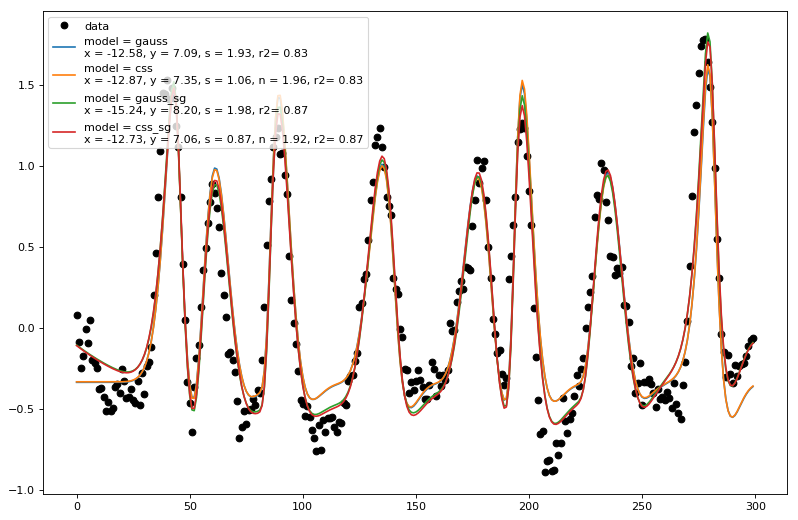

In [70]:
import matplotlib.pyplot as plt

vox = 3
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(data_to_analyse[:,vox],'ko',label='data')
num_plt = 0
for fit_model in ['gauss','css','gauss_sg','css_sg']:
    if fit_model == 'gauss':
        prf = prf_gauss
    elif fit_model == 'css':
        prf = prf_css
    elif fit_model == 'gauss_sg':
        prf = prf_gauss_sg
    elif fit_model == 'css_sg':
        prf = prf_css_sg
        
    num_plt += 1
#     plt.subplot(2, 2, num_plt)
    if fit_model == 'gauss' or fit_model == 'gauss_sg':
        plt.plot(prf.model_func.generate_prediction(prf.fit_output[vox,0],
                                                    prf.fit_output[vox,1],
                                                    prf.fit_output[vox,2],
                                                    prf.fit_output[vox,3],
                                                    prf.fit_output[vox,4]),
                                                    label = 'model = %s\nx = %1.2f, y = %1.2f, s = %1.2f, r2= %1.2f'
                                                    %(fit_model,prf.fit_output[vox,1],prf.fit_output[vox,2],prf.fit_output[vox,3],prf.fit_output[vox,-1])
                                                    )
        plt.legend()
    elif fit_model == 'css' or fit_model == 'css_sg':
        plt.plot(prf.model_func.generate_prediction(prf.fit_output[vox,0],
                                                    prf.fit_output[vox,1],
                                                    prf.fit_output[vox,2],
                                                    prf.fit_output[vox,3],
                                                    prf.fit_output[vox,4],
                                                    prf.fit_output[vox,5]),
                                                    label = 'model = %s\nx = %1.2f, y = %1.2f, s = %1.2f, n = %1.2f, r2= %1.2f'
                                                    %(fit_model,prf.fit_output[vox,1],prf.fit_output[vox,2],prf.fit_output[vox,3],prf.fit_output[vox,4],prf.fit_output[vox,-1])
                                                    )
        plt.legend()
plt.show()


